# Install of required package

This block only needs to be executed once to install the required packages in your python env.

In [1]:
# import sys
# !{sys.executable} -m pip uninstall smi-analysis --yes
# !{sys.executable} -m pip install git+https://github.com/gfreychet/smi-analysis.git
# !{sys.executable} -m pip uninstall saxs-nxformat --yes
# !{sys.executable} -m pip install git+https://github.com/CEA-MetroCarac/saxs_nxformat.git


Found existing installation: smi-analysis 0.1.0.post70+g87cab36
Uninstalling smi-analysis-0.1.0.post70+g87cab36:
  Successfully uninstalled smi-analysis-0.1.0.post70+g87cab36
  Cloning https://github.com/gfreychet/smi-analysis.git to c:\users\at280565\appdata\local\temp\pip-req-build-dtaokg4w
  Resolved https://github.com/gfreychet/smi-analysis.git to commit 87cab36948499bc82bfef49101843bfc13014bb7
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py install for smi-analysis: started
  Running setup.py install for smi-analysis: finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/gfreychet/smi-analysis.git 'C:\Users\AT280565\AppData\Local\Temp\pip-req-build-dtaokg4w'
  DEPRECATION: smi-analysis is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: C:\dev\sw\envs3\env_metrocarac\Scripts\python.exe -m pip install --upgrade pip


Found existing installation: saxs_nxformat 2025.3
Uninstalling saxs_nxformat-2025.3:
  Successfully uninstalled saxs_nxformat-2025.3
  Cloning https://github.com/CEA-MetroCarac/saxs_nxformat.git to c:\users\at280565\appdata\local\temp\pip-req-build-j5ltvvb4
  Resolved https://github.com/CEA-MetroCarac/saxs_nxformat.git to commit 54fcd73c724bcb7339abcf38246cef20f339eec4
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for saxs_nxformat: filename=saxs_nxformat-2025.3-py3-none-any.whl size=6276358 sha256=d5f3d4562564018fbe61271c94300f47c6ed4bcc836a57e3e5cb2f330333cfb8
  Stored in directory: C:\Users\AT280565\AppData\Local\Temp\pip-ephem-wheel-cache-81hofmja\wheels\9a\20\74\052151babf4924ba5f32632d

  Running command git clone --filter=blob:none --quiet https://github.com/CEA-MetroCarac/saxs_nxformat.git 'C:\Users\AT280565\AppData\Local\Temp\pip-req-build-j5ltvvb4'

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: C:\dev\sw\envs3\env_metrocarac\Scripts\python.exe -m pip install --upgrade pip


In [2]:
%matplotlib ipympl

import inspect
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import re

from pathlib import Path
from colorama import Fore, Style
from saxs_nxformat.class_nexus_file import NexusFile, save_data
from smi_analysis import SMI_beamline

# Inspecting your h5 file

This function can be used to visualize the structure of the HDF5 file.
There are three types of element :

    - Groups (red) : you can view them as a directory, it can contain other groups, dataset or attributes
    - Datasets (blue) : you can view them as a file, it can only contain attributes
    - Attributes (green) : you can view them as metadata, it cannot contain anything and gives additional information
    
You just have to pass the path of your data file in. Additionally you can choose wether you want to see what's in groups and what's inside datasets

In [3]:
def explore_file(group, explore_group=False, explore_dataset=False, level=0):
    indent = "|  " * level
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Group):
            print(f"{indent}{Fore.RED}Group : {key}{Style.RESET_ALL}")
            explore_file(item, explore_group, explore_dataset, level + 1)
        elif isinstance(item, h5py.Dataset) and explore_group:
            print(f"{indent}{Fore.CYAN}Dataset : {key}{Style.RESET_ALL}")
            if item.attrs and explore_dataset:
                print(f"{indent}  {Fore.GREEN}Attributes : {key}{Style.RESET_ALL}")
                for key_attribute, item_attribute in item.attrs.items():
                    print(f"{indent}    - {key_attribute} : {item_attribute}")

# Specify the directory containing your data files

Change the variable **data_dir** to the path of the directory containing your data. The data needs to have the HDF5 format with the NeXus standard to work properly.

In [4]:
data_dir = r"C:\Users\AT280565\Desktop\Data Treatment Center\Treated Data\instrument - XEUSS\year - 2025\config ID - 202503101406\experiment - measure\detector - SWAXS"

path_list = []

for file in os.listdir(data_dir):
    print(file)
    if file.endswith(".h5"):
        path_list.append(os.path.join(data_dir, file))
        print(file)

Glassy_Carbon_img00001_20250313155122.h5
Glassy_Carbon_img00001_20250313155305.h5
Glassy_Carbon_img00004_20250313155102.h5
Glassy_Carbon_img00004_20250313155226.h5
Glassy_Carbon_img00005_20250313155209.h5
Glassy_Carbon_img00008_20250313155130.h5


# Processing using the NexusFile class

## Opening your files
To open your file, you need to use the NexusFile class, pass a list of the paths of all the data you want to treat. There are 2 parameters to the constructor of this class:
- do_batch : This will determine wether you want to display your data in different graphs or in the same figure.
- input_data_group : This will determine what data group should be used as the raw data. By default it's the "DATA" group (the data as it came out of the machine). However, let's say you substracted the raw data by some background and saved it as "DATA_NO_BACK", you can put input_data_group="DATA_NO_BACK" to use this data as the raw data.

**Be careful** : 
- the input_data_group should be raw data or scaled raw data, I do not know what would happen if you put anything other than that.
- When you do a process use the try: / finally: environement as shown below. This is to ensure that the files are properly repacked and closed no matter what happens

[3.06405292 3.06153763 3.05902234 ... 0.48084925 0.47833396 0.47581867]
[ 0.11002656  0.10985756  0.10968856 ... -0.06894384 -0.06911284
 -0.06928184]
[3.06405292 3.06153763 3.05902234 ... 0.48084925 0.47833396 0.47581867]
[ 0.19863296  0.19832784  0.19802271 ... -0.12449674 -0.12480187
 -0.12510699]
[ 0.39616813  0.39555912  0.39495012 ... -0.24876917 -0.24937817
 -0.24998718]
[ 0.78412865  0.78292042  0.7817122  ... -0.49538317 -0.49659139
 -0.49779962]


C:\dev\sw\envs3\env_metrocarac\lib\site-packages\saxs_nxformat\class_nexus_file.py:1183: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig, self.ax = plt.subplots(dims, dims, layout="constrained")


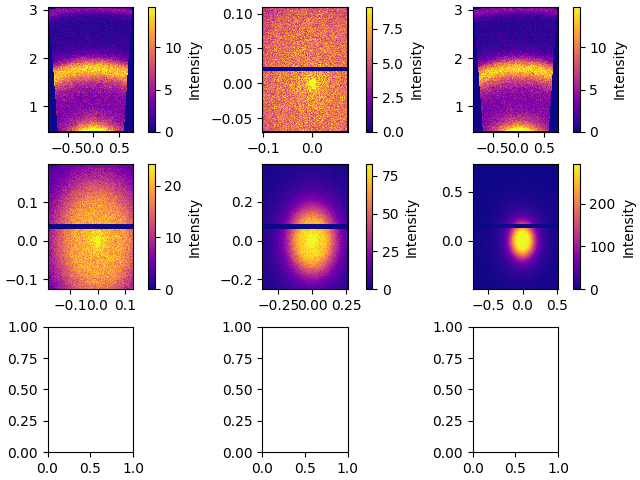

In [17]:
nx_files = NexusFile(path_list, do_batch=True)
try:
    # Do some process
    nx_files.process_q_space(save=True, display=False, group_name="DATA_Q_SPACE")
    nx_files.process_display(group_name="DATA_Q_SPACE")
except Exception as error:
    # Do something else if an error occurs
    print(error)
finally:
    nx_files.nexus_close() # Very important !

## Getting more info on a method

You can get a lot of information on a particular method of the NexusFile class by using the show_method method.\
By putting no parameters you only get a list of all the methods available in the class. If you put one of those name in the method it will show more info regarding that particular method :
- The docstring : A description of what the method does and what the parameters of this method do
- Default value : A list of all the parameters and their default value if they have one

In [18]:
nx_files = NexusFile(path_list, do_batch=True)
# Calling show_method without any parameter :
print(nx_files.show_method())

# Calling show method with the name of another method
print(nx_files.show_method("get_raw_data"))
nx_files.nexus_close()


__init__
_display_data
add_file
get_file
get_process_desc
get_raw_data
nexus_close
process_azimuthal_average
process_caking
process_delete_data
process_display
process_horizontal_integration
process_q_space
process_radial_average
process_vertical_integration
show_method
Please rerun this function and pass the name of one method as a parameter
to get more information concerning this particular method

get_raw_data
Docstring : 
        Get raw data of the group name. The parameter and intensity are returned as python dict :
            - key : file name
            - value : param | intensity

        Parameters
        ----------
        group_name :
            name of the group that contains the data to extract

        Returns
        -------
        2 dict :
            - The first one contains the parameter
            - The second one contains the intensity

        
    group_name='DATA_Q_SPACE'


## Viewing what's inside the HDF5 file

Now is the time to check what is in the .h5 file using the function explore_file defined earlier

In [19]:
explore_file(h5py.File(path_list[0]), False, False)

Group : ENTRY
|  Group : COLLECTION
|  Group : DATA
|  Group : DATA_Q_SPACE
|  Group : DATA_RAD_AVG
|  Group : INSTRUMENT
|  |  Group : APERTURE
|  |  Group : COLLIMATOR
|  |  Group : DETECTOR
|  |  Group : SOURCE
|  Group : PROCESS
|  Group : PROCESS_Q_SPACE
|  Group : PROCESS_RAD_AVG
|  Group : SAMPLE


## Displaying your data

Nativelly, raw data and some basic processes should be inside groups called DATA_..., which are themselves in a group called ENTRY

If you want to see those datasets you can simply call the display method as we saw earlier.

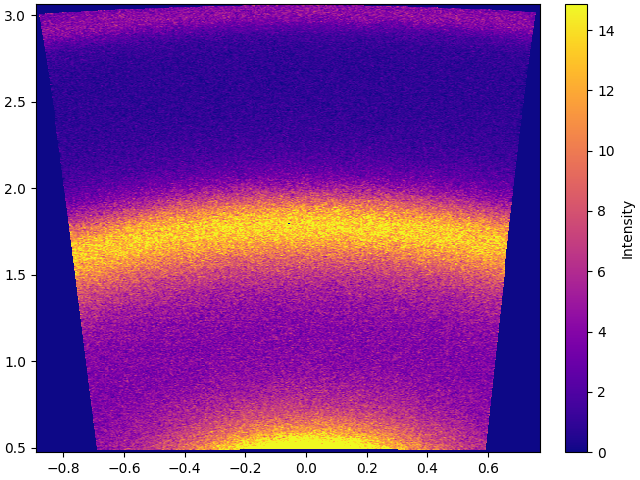

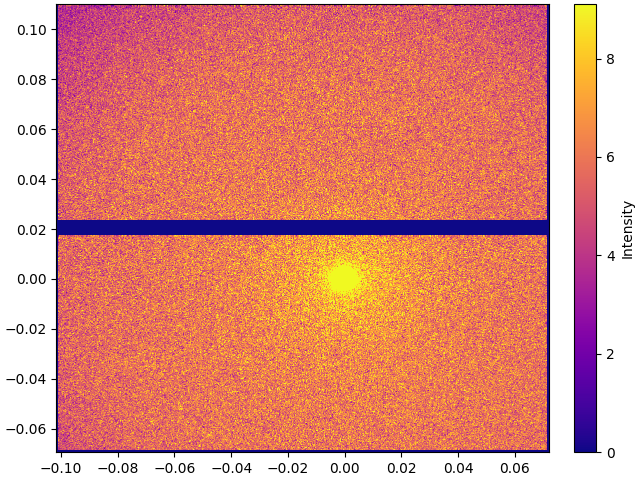

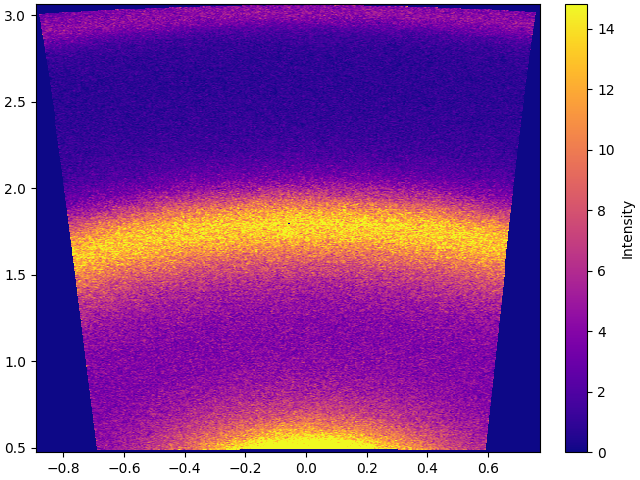

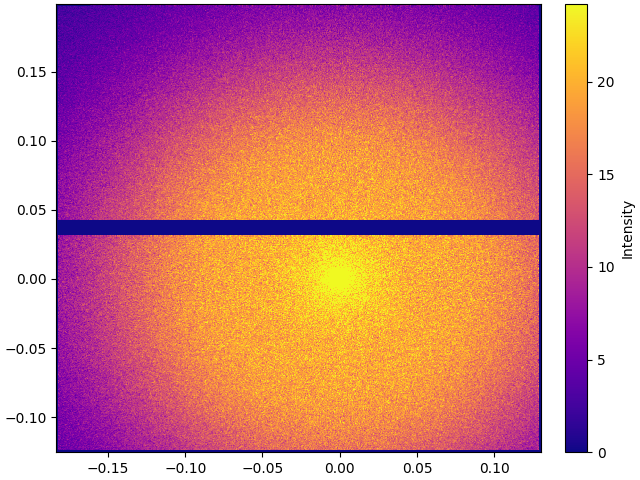

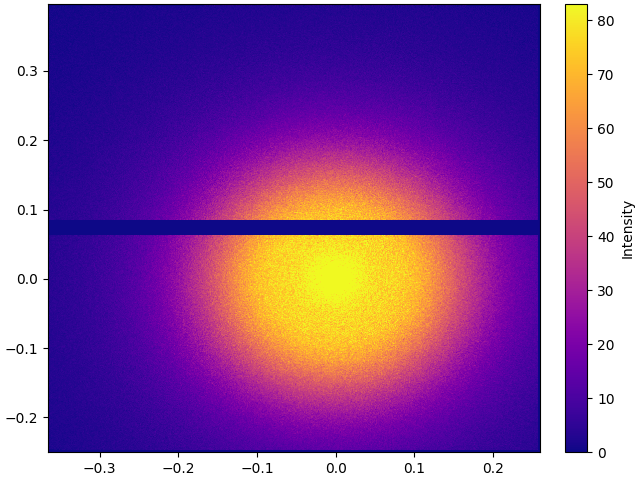

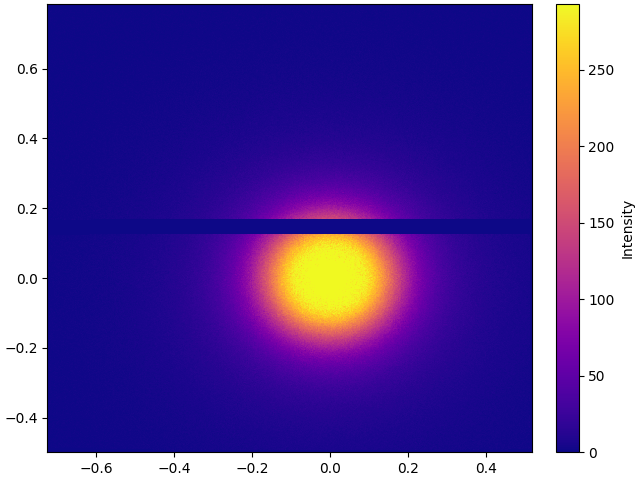

In [20]:
nx_files = NexusFile(path_list, do_batch=False)
try:
    nx_files.process_display(group_name="DATA_Q_SPACE")
except Exception as error:
    print(error)
finally:
    nx_files.nexus_close()

## Applying premade processes

You can do more processes on your data by calling the other methods of the NexusFile class. let's do caking for example.

For most processes, you can display and/or save the processes data to your HDF5 file while keeping the raw data.

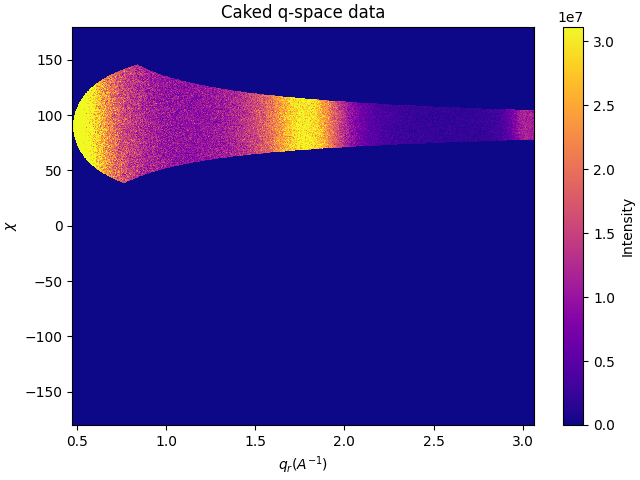

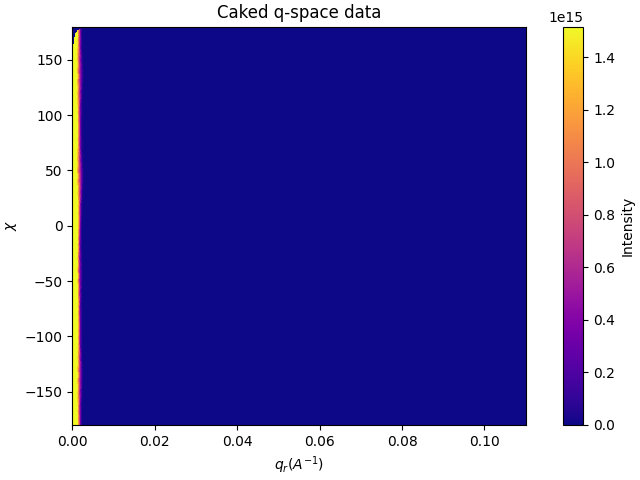

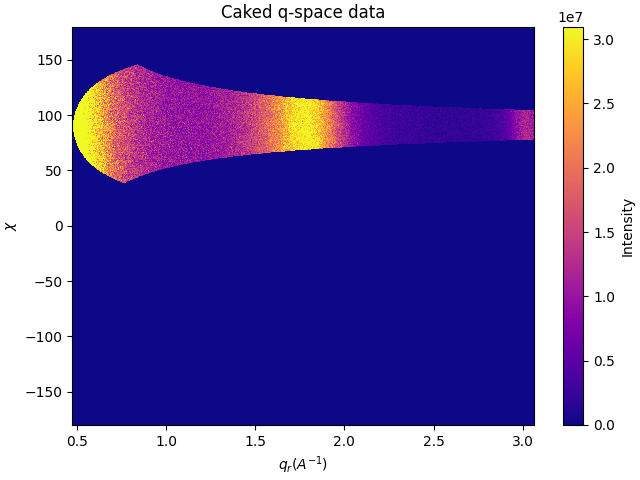

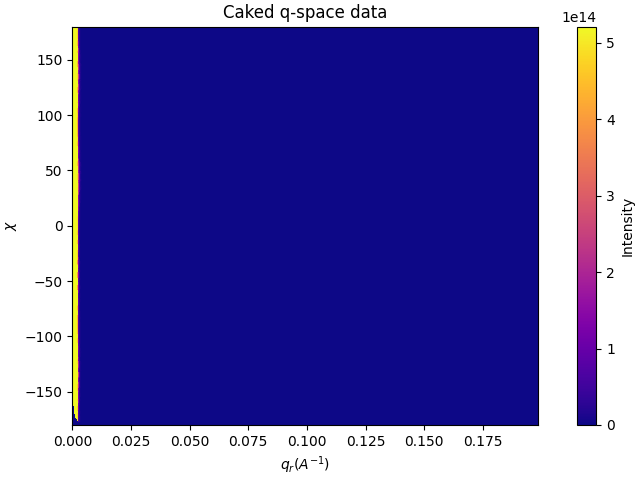

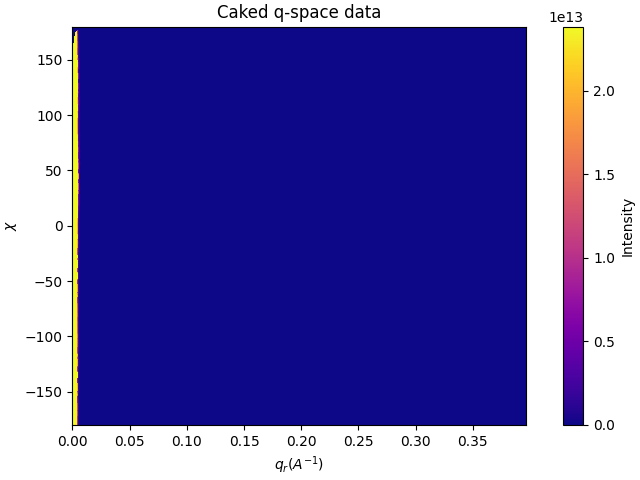

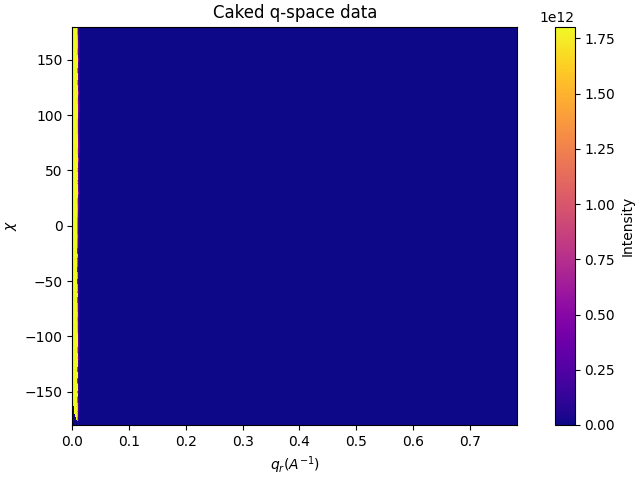

In [21]:
nx_files = NexusFile(path_list, do_batch=False)
try:
    nx_files.process_caking(display=True, save=True, group_name="DATA_CAKED")
except Exception as error:
    print(error)
finally:
    nx_files.nexus_close()

 We can check and see if the data has been saved properly

In [26]:
explore_file(h5py.File(path_list[0]), False, False)

Group : ENTRY
|  Group : COLLECTION
|  Group : DATA
|  Group : DATA_CAKED
|  Group : DATA_Q_SPACE
|  Group : DATA_RAD_AVG
|  Group : INSTRUMENT
|  |  Group : APERTURE
|  |  Group : COLLIMATOR
|  |  Group : DETECTOR
|  |  Group : SOURCE
|  Group : PROCESS
|  Group : PROCESS_CAKED
|  Group : PROCESS_Q_SPACE
|  Group : PROCESS_RAD_AVG
|  Group : SAMPLE


As we can see, a new group called DATA_CAKED was created !
There is also an associated PROCESS_CAKED that was created

## Showing what's in PROCESS_...

You can display what's in PROCES_... by using the method get_process_desc. This method return a python dictionnary :
- The key is the name of the file
- The value is the description of the process for that particular file

Each process contains a short description of what is the process and what were the parameters used to get this particular result

In [28]:
nx_files = NexusFile(path_list, do_batch=False)
try:
    desc = nx_files.get_process_desc(group_name="PROCESS_CAKED")
except Exception as error:
    print(error)
finally:
    nx_files.nexus_close()

for key, value in desc.items():
    print(key)
    print(value)

Glassy_Carbon_img00001_20250313155122.h5
This process plots the intensity with respect to the azimuthal angle and the distance from the center of the q-space.
Parameters used :
   - Azimuthal range : [-180.0000, 180.0000] with 1000 points
   - Radial Q range : [0.4758, 3.0641] with 1000 points

Glassy_Carbon_img00001_20250313155305.h5
This process plots the intensity with respect to the azimuthal angle and the distance from the center of the q-space.
Parameters used :
   - Azimuthal range : [-180.0000, 180.0000] with 1000 points
   - Radial Q range : [-0.0693, 0.1100] with 1000 points

Glassy_Carbon_img00004_20250313155102.h5
This process plots the intensity with respect to the azimuthal angle and the distance from the center of the q-space.
Parameters used :
   - Azimuthal range : [-180.0000, 180.0000] with 1000 points
   - Radial Q range : [0.4758, 3.0641] with 1000 points

Glassy_Carbon_img00004_20250313155226.h5
This process plots the intensity with respect to the azimuthal angle a

## Getting raw data

Let's say we do the radial average but we would like to get the raw data to do some fitting or some other thing.
You can always get the raw data by using the method get_raw_data.

This method return 2 dictionnary :
- the first one contains the data of the parameter (commonly a list of vector Q)
- The second one contains the data of the measure (commonly a list of intensity)

The key is the name of the file and the value is the data associated to this file

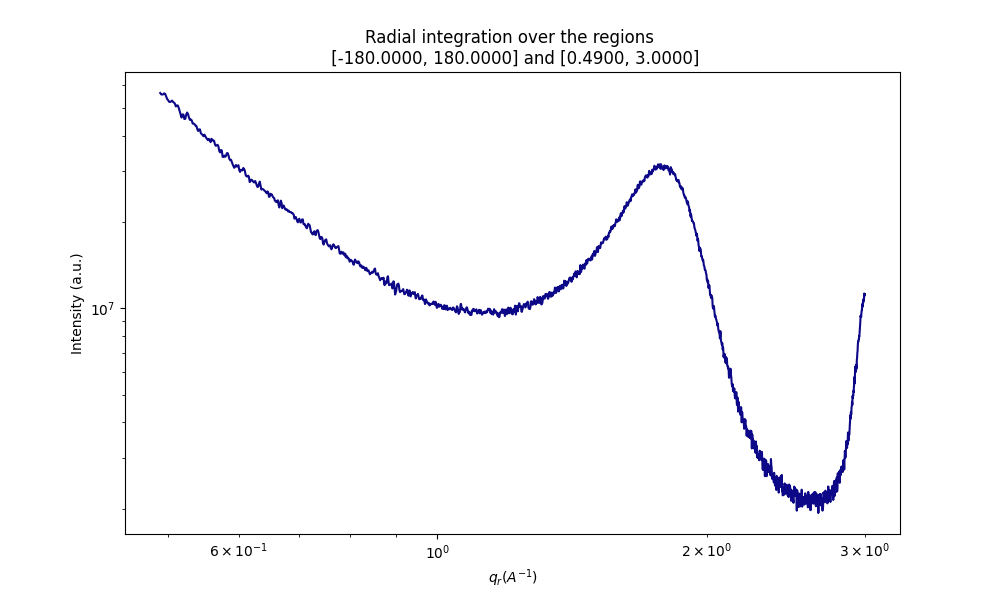

In [29]:
nx_files = NexusFile(path_list[0], do_batch=False)
try: 
    nx_files.process_radial_average(display=True, save=True, r_min=0.49, r_max=3)
    Q_dict, I_dict = nx_files.get_raw_data(group_name="DATA_RAD_AVG")
except Exception as error:
    print(error)
finally:
    nx_files.nexus_close()

We plot the data we just got to be sure it's the same

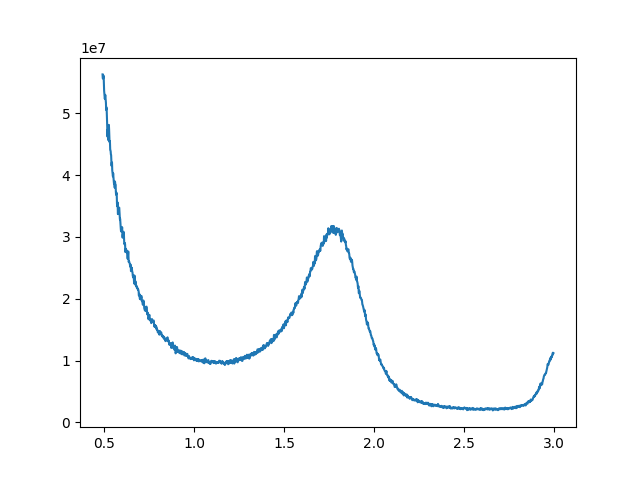

In [30]:
file_path = Path(path_list[0])
file_name = file_path.name
q_file1 = Q_dict[file_name]
i_file1 = I_dict[file_name]

plt.figure()
plt.plot(q_file1, i_file1)
plt.show()

We did get the exact same data

Let's do a Naive normalization process on this data

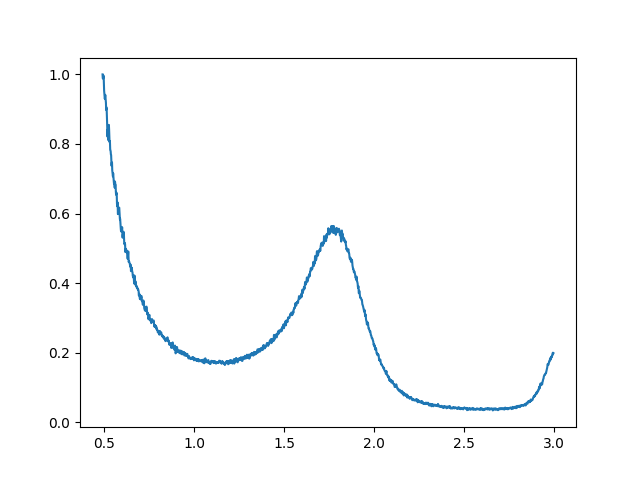

In [31]:
# For example we normalize the data
max_i = np.max(i_file1)
i_file1 = i_file1 / max_i

plt.figure()
plt.plot(q_file1, i_file1)
plt.show()


Now we can save the data to the HDF5 file by using the save_data function from the saxs_nxformat.class_nexus_file script

In [33]:
with h5py.File(path_list[0], "r+") as nx_file:
    save_data(nx_file, "Q", q_file1, "DATA_RAD_AVG_NORM", i_file1, [])

We can check and see if the data has been saved successfully

In [34]:
explore_file(h5py.File(path_list[0]), False, False)

Group : ENTRY
|  Group : COLLECTION
|  Group : DATA
|  Group : DATA_CAKED
|  Group : DATA_Q_SPACE
|  Group : DATA_RAD_AVG
|  Group : DATA_RAD_AVG_NORM
|  Group : INSTRUMENT
|  |  Group : APERTURE
|  |  Group : COLLIMATOR
|  |  Group : DETECTOR
|  |  Group : SOURCE
|  Group : PROCESS
|  Group : PROCESS_CAKED
|  Group : PROCESS_Q_SPACE
|  Group : PROCESS_RAD_AVG
|  Group : SAMPLE


We can see the data has been saved, let's display it using the NexusFile method

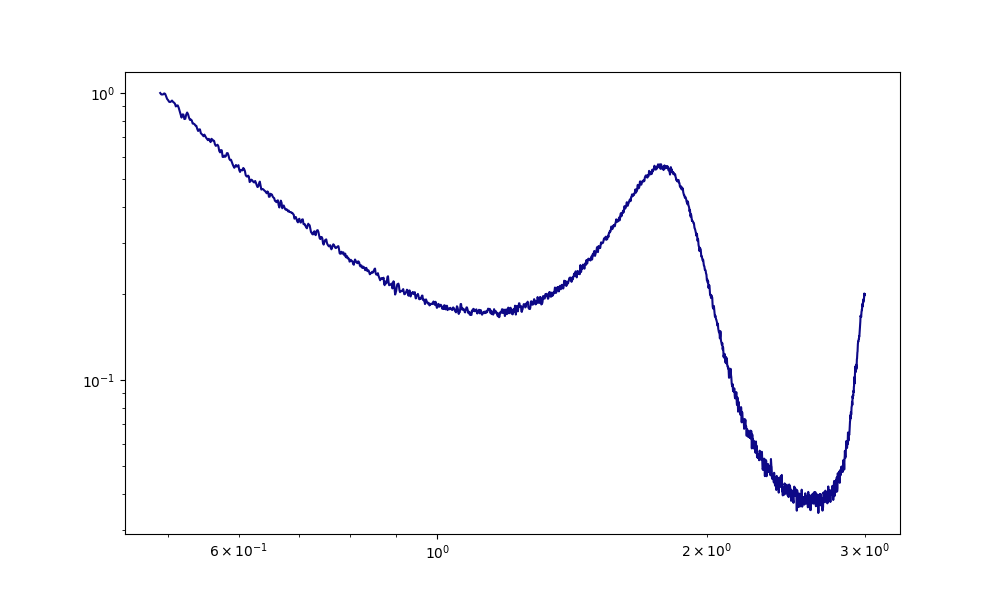

In [36]:
nx_files = NexusFile(path_list[0], do_batch=False)
try: 
    nx_files.process_display(group_name="DATA_RAD_AVG_NORM")
except Excpetion as error:
    print(error)
finally:
    nx_files.nexus_close()

# Troubleshooting

1. In case you forgot to use the try: / finally: environement and you're having some error saying a file is already used by a process : Close the notebook and the command invite and go to the directory where your files are, there should be a .tmp file, you can delete it and reopen the notebook. To avoid this error please use the try: / environement: 